# Flight Data Analysis - Airbus

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import norm
import scipy.special as sc

## I. Data Set

In [351]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [352]:
#file_location = '/content/drive/My Drive/data_projet5A/INSA-Airbus FHS - Dataset_ter.xlsx'
file_location = "../Flight_Data_Analysis/Dataset_ter.xlsx"
Removals = pd.read_excel(file_location, sheet_name='Removals')
SNlist = pd.read_excel(file_location, sheet_name='SN list')

In [353]:
Removals.info()
Removals.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Customer                       2388 non-null   int64         
 1   Removal date                   2388 non-null   datetime64[ns]
 2   P/N                            2388 non-null   object        
 3   Description                    2388 non-null   object        
 4   S/N                            2388 non-null   object        
 5   Maintenance Type               2388 non-null   object        
 6   TSI (Flight Hours) at removal  2296 non-null   float64       
 7   TSN (Flight Hours) at Removal  2335 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 149.4+ KB


,Customer,Removal date,P/N,Description,S/N,Maintenance Type,TSI (Flight Hours) at removal,TSN (Flight Hours) at Removal
0,3,2015-01-01,C,PN_C,15323054356,Unscheduled,5819.0,5819.0
1,3,2015-01-01,C,PN_C,15323057041,Unscheduled,5819.0,5819.0
2,3,2015-01-03,C,PN_C,15323072973,Unscheduled,3036.0,3036.0
3,3,2015-01-07,C,PN_C,15323053425,Unscheduled,5614.0,5614.0
4,3,2015-01-07,C,PN_C,15323058236,Unscheduled,5614.0,5614.0


In [354]:
SNlist.info()
SNlist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5785 entries, 0 to 5784
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Part Number                     5785 non-null   object 
 1   Description                     5785 non-null   object 
 2   Serial Number                   5785 non-null   object 
 3   Current SN Status Description   5785 non-null   object 
 4   Company                         5784 non-null   object 
 5   Hour ageing Since Installation  5745 non-null   float64
 6   Hour ageing Since New           5637 non-null   float64
 7   Since New Date                  4350 non-null   object 
dtypes: float64(2), object(6)
memory usage: 361.7+ KB


,Part Number,Description,Serial Number,Current SN Status Description,Company,Hour ageing Since Installation,Hour ageing Since New,Since New Date
0,A,PN_A,XXXM01-00324,On Aircraft,5,39498.39,54222.37,2007-11-19 00:00:00
1,A,PN_A,XXXM01-00329,On Aircraft,5,54525.41,54525.41,2007-11-19 00:00:00
2,A,PN_A,XXXM01-00334,On Aircraft,5,32238.92,52831.08,2008-03-12 00:00:00
3,A,PN_A,XXXM01-00337,On Aircraft,5,6951.19,52169.46,2006-04-01 00:00:00
4,A,PN_A,XXXM01-00338,On Aircraft,5,55511.55,55511.55,2008-03-12 00:00:00


##### Combining Removals and SNlist :

In [355]:
fail_and_not = SNlist.copy()
fail_and_not['failed'] = False
fail_and_not[fail_and_not['Current SN Status Description']=='In Outside Repair']=True
fail_and_not = fail_and_not.drop(['Description','Current SN Status Description','Since New Date','Company'], axis = 1)
fail_and_not = fail_and_not.rename(columns={"Part Number": "PN", "Serial Number": "SN", "Hour ageing Since Installation": "TSI", "Hour ageing Since New": "TSN"})
#dic_PN = {"C":"C","C-new":"C","A":"A","B":"B"}
dic_PN = {"C":"C","C-new":"C-new","A":"A","B":"B"}
fail_and_not["PN"] = fail_and_not.PN.map(dic_PN)

fail = Removals[Removals['Maintenance Type']=='Unscheduled']
fail = fail.drop(['Customer','Removal date','Description','Maintenance Type'], axis=1)
fail = fail.rename(columns={"P/N": "PN", "S/N": "SN", "TSI (Flight Hours) at removal": "TSI", "TSN (Flight Hours) at Removal": "TSN"})
fail['failed'] = True
fail['PN'] = fail.PN.map(dic_PN)

all_SN = pd.unique(fail_and_not['SN'])
SN_Removals = pd.unique(fail['SN'])

combined = pd.concat([fail,fail_and_not], ignore_index=True)
combined = combined.drop_duplicates(subset=['SN','PN','TSN'], keep='last')

In [356]:
pd.unique(combined['PN'])

array(['C', 'B', 'A', 'C-new', nan], dtype=object)

##### Data errors treatment

In [357]:
combined['TSI']=combined['TSI'].replace(np.nan, 0.0)
combined['TSN']=combined['TSN'].replace(np.nan, 0.0)
combined = combined[combined['TSN']!=0]
combined.head()

,PN,SN,TSI,TSN,failed
0,C,15323054356,5819,5819,True
1,C,15323057041,5819,5819,True
2,C,15323072973,3036,3036,True
3,C,15323053425,5614,5614,True
4,C,15323058236,5614,5614,True


In [358]:
print(len(set(combined['SN'])),'/',len(combined), 'distinct number part.')

6005 / 7758 distinct number part.


## II. Data Visualization 

In [359]:
data = combined.copy()

### 1. Type A, B, C

Number of samples in total :  7758


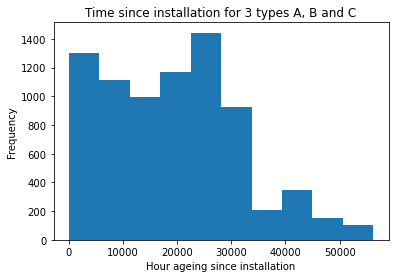

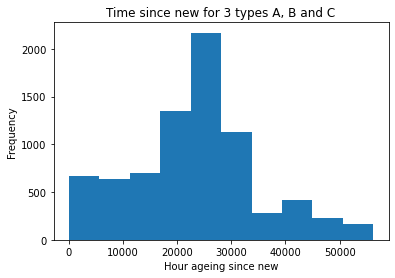

In [360]:
plt.hist(data['TSI'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Hour ageing since installation')
plt.title('Time since installation for 3 types A, B and C')
plt.figure()
plt.hist(data['TSN'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Hour ageing since new')
plt.title('Time since new for 3 types A, B and C')

print("Number of samples in total : ", len(data['TSI']))

### 2. Type A

Number of samples type A :  3255


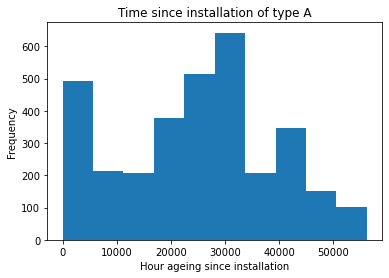

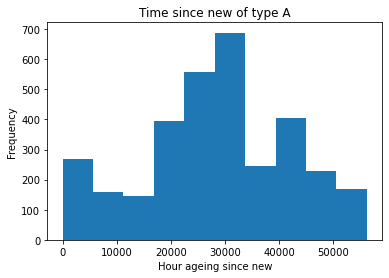

In [361]:
plt.hist(data[data['PN']=='A']['TSI'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Hour ageing since installation')
plt.title('Time since installation of type A')
plt.figure()
plt.hist(data[data['PN']=='A']['TSN'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Hour ageing since new')
plt.title('Time since new of type A')

print("Number of samples type A : ", len(data[data['PN']=='A']['TSI']))

### 3. Type B

Number of samples type B :  287


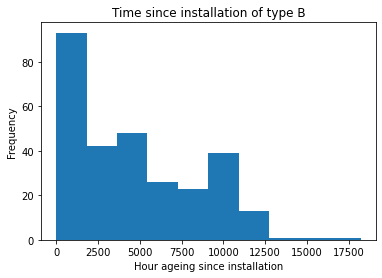

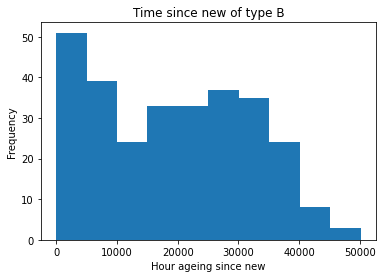

In [362]:
plt.hist(data[data['PN']=='B']['TSI'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Hour ageing since installation')
plt.title('Time since installation of type B')
plt.figure()
plt.hist(data[data['PN']=='B']['TSN'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Hour ageing since new')
plt.title('Time since new of type B')

print("Number of samples type B : ", len(data[data['PN']=='B']['TSI']))

### 4. Type C

Number of samples type C :  3317


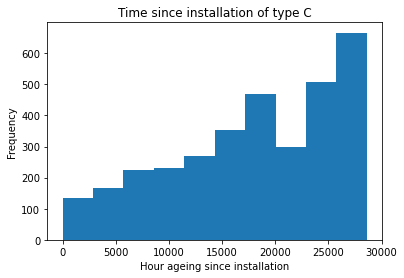

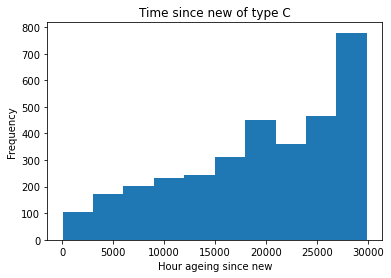

In [363]:
plt.hist(data[data['PN']=='C']['TSI'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Hour ageing since installation')
plt.title('Time since installation of type C')
plt.figure()
plt.hist(data[data['PN']=='C']['TSN'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Hour ageing since new')
plt.title('Time since new of type C')

print("Number of samples type C : ", len(data[data['PN']=='C']['TSI']))

### 5. Type C-new

Number of samples type C-new :  898


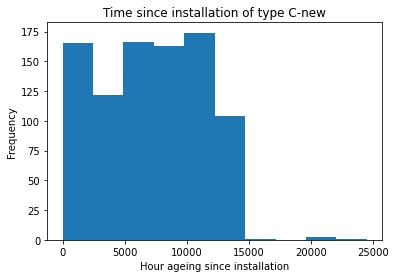

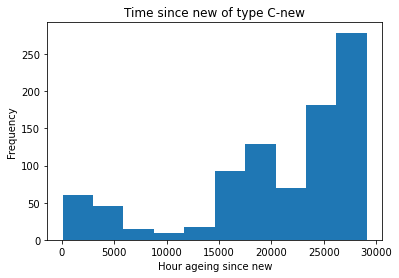

In [364]:
plt.hist(data[data['PN']=='C-new']['TSI'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Hour ageing since installation')
plt.title('Time since installation of type C-new')
plt.figure()
plt.hist(data[data['PN']=='C-new']['TSN'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Hour ageing since new')
plt.title('Time since new of type C-new')

print("Number of samples type C-new : ", len(data[data['PN']=='C-new']['TSI']))

## III. Data Analysis

We first consider the Nelson-Aalen estimator and the Kaplan-Meier estimator which will be used to compare with the model we apply for data in each cases.

(Note that we need to install the "lifelines" package for Python).

In [365]:
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

data_A = data[data['PN']=='A']
T_A = data_A.TSI
d_A = np.array([1 if f == True else 0 for f in data_A.failed])

data_B = data[data['PN']=='B']
T_B = data_B.TSI
d_B = np.array([1 if f == True else 0 for f in data_B.failed])

data_C = data[data['PN']=='C']
T_C = data_C.TSI
d_C = np.array([1 if f == True else 0 for f in data_C.failed])

data_Cnew = data[data['PN']=='C-new']
T_Cnew = data_Cnew.TSI
d_Cnew = np.array([1 if f == True else 0 for f in data_Cnew.failed])

/home/nnthuynh/anaconda3/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/nnthuynh/anaconda3/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/nnthuynh/anaconda3/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/nnthuynh/a

Text(0.5, 1.0, 'Cumulative hazard function and its confidence interval by Kaplan Meier estimator')

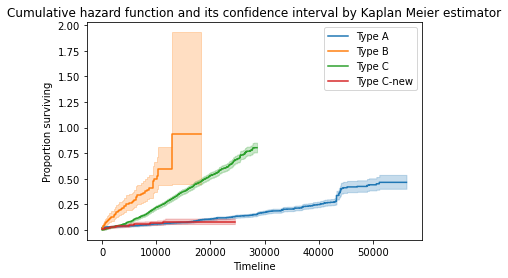

In [366]:
alpha = 0.05 # coefficient related to confidence levels

## create the naf objects
naf_A = NelsonAalenFitter()
naf_B = NelsonAalenFitter() 
naf_C = NelsonAalenFitter() 
naf_Cnew = NelsonAalenFitter() 

## Fit the data into the model
naf_A.fit(T_A, d_A,alpha=alpha,label="Type A")
naf_B.fit(T_B, d_B,alpha=alpha,label="Type B")
naf_C.fit(T_C, d_C,alpha=alpha,label="Type C")
naf_Cnew.fit(T_Cnew, d_Cnew,alpha=alpha,label="Type C-new")

## Create an estimate
naf_A.plot(ci_show=True)
naf_B.plot(ci_show=True)
naf_C.plot(ci_show=True)
naf_Cnew.plot(ci_show=True)
plt.ylabel('Proportion surviving')
plt.xlabel('Timeline')
plt.title('Cumulative hazard function and its confidence interval by Kaplan Meier estimator')

/home/nnthuynh/anaconda3/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/nnthuynh/anaconda3/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/nnthuynh/anaconda3/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/nnthuynh/a

Text(0.5, 1.0, 'Reliability function and its confidence interval by Kaplan Meier estimator')

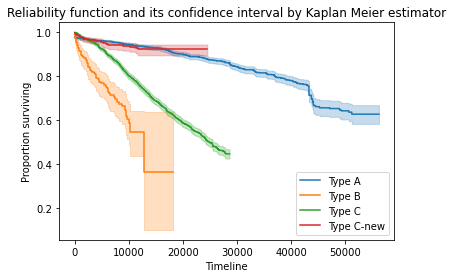

In [367]:
## create the kmf objects
kmf_A = KaplanMeierFitter()
kmf_B = KaplanMeierFitter() 
kmf_C = KaplanMeierFitter() 
kmf_Cnew = KaplanMeierFitter() 

## Fit the data into the model
kmf_A.fit(T_A, d_A,alpha=alpha,label="Type A")
kmf_B.fit(T_B, d_B,alpha=alpha,label="Type B")
kmf_C.fit(T_C, d_C,alpha=alpha,label="Type C")
kmf_Cnew.fit(T_Cnew, d_Cnew,alpha=alpha,label="Type C-new")

## Create an estimate
kmf_A.plot(ci_show=True)
kmf_B.plot(ci_show=True)
kmf_C.plot(ci_show=True)
kmf_Cnew.plot(ci_show=True)
plt.ylabel('Proportion surviving')
plt.xlabel('Timeline')
plt.title('Reliability function and its confidence interval by Kaplan Meier estimator')

### 1. Parametric model score checking:

In [368]:
def model_checking(t,h,data_type,models = ["Exponential model","Weibull model","Log-normal"]):
    t_log = np.log(t)[1:]
    h_log = np.log(h)[1:]
    
    h_inv = norm.ppf(1-np.exp(-h),loc=0,scale=1)[1:]
    
    print('Score of', models[0], 'of type', data_type, 'is', stats.linregress(h,t).rvalue**2)
    print('Score of', models[1], 'of type', data_type, 'is', stats.linregress(h_log,t_log).rvalue**2)
    print('Score of', models[2], 'of type', data_type, 'is', stats.linregress(h_inv,t_log).rvalue**2)

In [369]:
tl_A = np.array(naf_A.timeline)
ch_A = np.array(naf_A.cumulative_hazard_)
ch_A = np.reshape(ch_A,-1)

tl_B = np.array(naf_B.timeline)
ch_B = np.array(naf_B.cumulative_hazard_)
ch_B = np.reshape(ch_B,-1)

tl_C = np.array(naf_C.timeline)
ch_C = np.array(naf_C.cumulative_hazard_)
ch_C = np.reshape(ch_C,-1)

tl_Cnew = np.array(naf_Cnew.timeline)
ch_Cnew = np.array(naf_Cnew.cumulative_hazard_)
ch_Cnew = np.reshape(ch_Cnew,-1)

t = [tl_A,tl_B,tl_C,tl_Cnew]
h = [ch_A,ch_B,ch_C,ch_Cnew]
data_type = ['A','B','C','Cnew']

for i in range(len(data_type)):
    model_checking(t[i],h[i],data_type[i])

Score of Exponential model of type A is 0.9011287908304255
Score of Weibull model of type A is 0.6903917078870316
Score of Log-normal of type A is 0.6333447792866229
Score of Exponential model of type B is 0.9671411546422601
Score of Weibull model of type B is 0.9225317526594042
Score of Log-normal of type B is 0.8531578969446063
Score of Exponential model of type C is 0.9928116211270029
Score of Weibull model of type C is 0.9876852341535235
Score of Log-normal of type C is 0.9441380127641117
Score of Exponential model of type Cnew is 0.9178562506016699
Score of Weibull model of type Cnew is 0.986260121419431
Score of Log-normal of type Cnew is 0.9824827672687375


### 2. For type B data

We hope to apply an exponential model for the data type B. So we first want to find an exponential model for the data, then we check whether this model is relevant and finally, we will give the interpretation results thanks to the considered model.


#### 2.1. Exponential Model

- Estimating the $\lambda$ coefficient with censoring data :

In [370]:
data_B = data[data['PN']=='B']
data_B_TSI = data_B[data_B['failed'] == True]['TSI'] # With censored data
lamb = len(data_B_TSI)/np.sum(data[data['PN']=='B']['TSI'])
print('lambda =', lamb)
print("Number of data type B :",len(data_B))
print('Number of censored data :',len(data_B)-len(data_B_TSI))

lambda = 5.396291034926614e-05
Number of data type B : 287
Number of censored data : 216


- Plotting simulated data :

Text(0.5, 1.0, 'Exponential distribution for type B data')

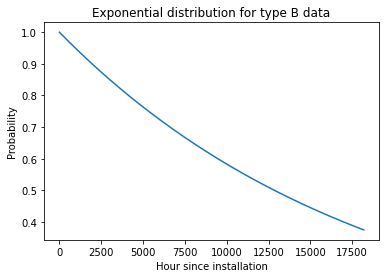

In [371]:
t=np.linspace(0,np.max(data_B.TSI),1000000)
y=pow(np.e,-lamb*t)
plt.plot(t,y)
plt.ylabel('Probability')
plt.xlabel('Hour since installation')
plt.title('Exponential distribution for type B data')

- Mean time to faillure :

In [372]:
print('The average time since installation of type B :', 1/lamb, 'hours.')

The average time since installation of type B : 18531.246619718302 hours.


#### 2.2. Model checking

- Comparing with the Kaplan-Meier estimator :

Text(0.5, 0, 'Timeline')

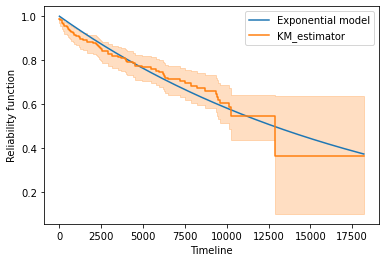

In [373]:
plt.plot(t,y)
kmf_B.plot()
plt.legend(('Exponential model', 'KM_estimator'))
plt.ylabel('Reliability function')
plt.xlabel('Timeline')

- Hazard plotting :

Now we want to check if the hazard plotting with exponential distribution gives us a acceptable score.

Score related R_square : 0.9671411546422601


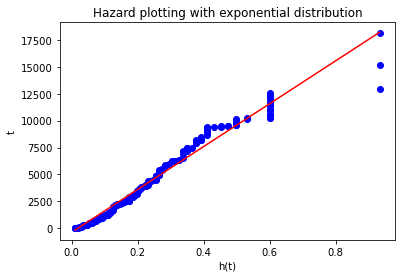

In [374]:
# linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(ch_B,tl_B)
# plot line
plt.scatter(ch_B,tl_B,c = 'b')
plt.plot(ch_B,slope*ch_B+intercept, c = 'r')
plt.title('Hazard plotting with exponential distribution')
plt.ylabel('t')
plt.xlabel('h(t)')
print("Score related R_square :", r_value**2)

The score of this model is 0.967. We can also see that the weibull model gives a less score:

Score related R_square : 0.9225317526594042


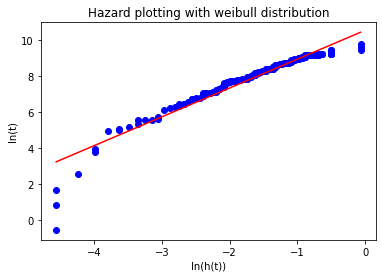

In [375]:
t=np.log(tl_B)[1:]
h=np.log(ch_B)[1:]
# linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(h,t)
# plot line
plt.scatter(h,t,c = 'b')
plt.plot(h,slope*h+intercept, c = 'r')
plt.title('Hazard plotting with weibull distribution')
plt.ylabel('ln(t)')
plt.xlabel('ln(h(t))')
print("Score related R_square :", r_value**2)

#### 2.3. Interpretation

### 3. For type A

#### 3.1. Parametric model checking (exponential distribution)

Text(0.5, 0, 'Timeline')

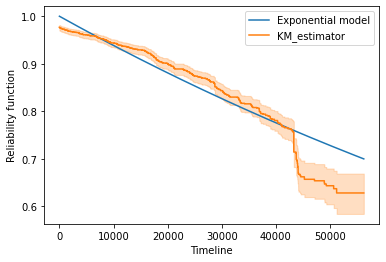

In [376]:
data_A = data[data['PN']=='A']
data_A_TSI = data_A[data_A['failed'] == True]['TSI'] # With censored data
lamb = len(data_A_TSI)/np.sum(data[data['PN']=='A']['TSI'])
t=np.linspace(0,np.max(data_A.TSI),1000000)
y=pow(np.e,-lamb*t)
plt.plot(t,y)
kmf_A.plot()
plt.legend(('Exponential model', 'KM_estimator'))
plt.ylabel('Reliability function')
plt.xlabel('Timeline')

We see that exponential model do not adapt our data in this case. So we keep the Kaplan_Meier model (non-parametric model) for the data type A.

#### 3.2. Interpretation

### 4. For type C

#### 4.1. Parametric model checking (exponential distribution)

Text(0.5, 0, 'Timeline')

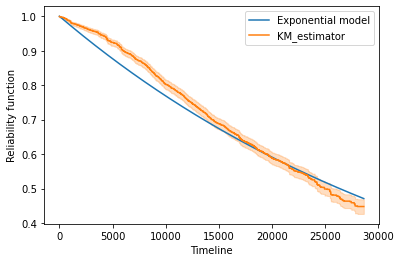

In [377]:
data_C = data[data['PN']=='C']
data_C_TSI = data_C[data_C['failed'] == True]['TSI'] # With censored data
lamb = len(data_C_TSI)/np.sum(data[data['PN']=='C']['TSI'])
t=np.linspace(0,np.max(data_C.TSI),1000000)
y=pow(np.e,-lamb*t)
plt.plot(t,y)
kmf_C.plot()
plt.legend(('Exponential model', 'KM_estimator'))
plt.ylabel('Reliability function')
plt.xlabel('Timeline')

#### 4.2. Interpretation

### 5. For type C-new

#### 5.1. Parametric model checking (weibull distribution)

<ipython-input-378-65270e0446a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_Cnew[T_Cnew==0]=1e-6 # Avoid divising by zero.
/home/nnthuynh/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


Text(0.5, 0, 'Timeline')

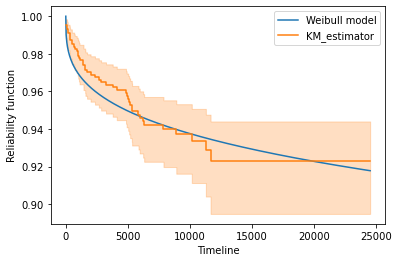

In [378]:
from lifelines import WeibullFitter

T_Cnew[T_Cnew==0]=1e-6 # Avoid divising by zero.
wb_Cnew = WeibullFitter() 
wb_Cnew.fit(T_Cnew, d_Cnew)
wb_Cnew.survival_function_.plot()
kmf_Cnew.plot()
plt.legend(('Weibull model', 'KM_estimator'))
plt.ylabel('Reliability function')
plt.xlabel('Timeline')

We accept this model.

In [379]:
alp = wb_Cnew.lambda_
beta = wb_Cnew.rho_
print("The MTTF of type Cnew is", sc.gammaln(1+1/beta)*alp, 'hours.')

The MTTF of type Cnew is 110425913.21639226 hours.


#### 5.2. Interpretation

In [380]:
def KME(t,T,d):
    x = np.min([t,np.max(T)])
    T_sort = np.sort(T)
    T_uniq = pd.unique(T_sort)
    ind = np.hstack([np.where(T==value)[0] for value in T_uniq])
    d_sort = np.array(d)[ind]
    
    T_sort = T_sort[:len(np.where(T_sort<x)[0])]
    d_sort = d_sort[:len(T_sort)]
    
    M = np.hstack([np.sum(d_sort[np.where(T_sort==val)[0]]) for val in T_uniq])
    Y = np.hstack([len(T)]+[len(T)-np.sum(M[:i+1]) for i in range(len(M)-1)])
    R = np.prod(np.ones(len(M))-M/Y)
    return R